# 迁移学习
  
实际中，基本没有人会从零开始（随机初始化）训练一个完整的卷积网络，因为相对于网络，很难得到一个足够大的数据集。通常的做法是在一个很大的数据集上进行预训练得到卷积网络ConvNet, 然后将这个ConvNet的参数作为目标任务的初始化参数或者固定这些参数。


#### 迁移学习的两个主要场景：
  
微调**Convnet**：使用预训练的网络(如在imagenet 1000上训练而来的网络)来初始化自己的网络，而不是随机初始化。  
将**Convnet**看成固定的特征提取器:首先固定ConvNet除了最后的全连接层外的其他所有层。最后的全连接层被替换成一个新的随机初始化的层，只有这个新的层会被训练。

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import time 
import os
import copy

plt.ion()

In [2]:
# 加载数据(ImageNet数据中一个很小的子集)
# 训练集数据扩充和归一化 
# 在验证集上仅需要归一化
data_transforms = {
    'train':transforms.Compose([
        transforms.RandomResizedCrop(224),  # 随机裁剪一个area然后再resize 
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val':transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                         data_transforms[x])
                 for x in ['train', 'val']}
dataloaders = {x : torch.utils.data.DataLoader(image_datasets[x], batch_size = 4, 
                                              shuffle = True, num_workers = 1)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


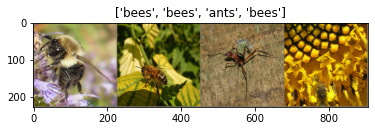

In [3]:
# 可视化
def imshow(inp, title = None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225]) 
    inp = std * inp + mean
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)
imshow(out, title = [class_names[x] for x in classes])

In [22]:
# 训练模型
def train_model(model, citerion, optimizer, scheduler, epochs = 25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    time_ela = time.time() - since
    print('Training compolete in {:.0f}m {:.0f}s'.format(time_ela // 60, time_ela % 60))
    print('Best val Acc: {:.4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

In [17]:
# 可视化预测结果
def visualize_model(model, num_images = 6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(model = was_training)

### 场景1：微调ConvNet

##### finetune
1: !加载预训练模型

In [7]:
model_ft = models.resnet18(pretrained = True)
num_ftrs = model_ft.fc.in_features  # 最后fc层的输入
model_ft.fc = nn.Linear(num_ftrs, 2)  # 2在这里表示class的数量

model_ft = model_ft.to(device)

In [8]:
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr = 0.001, momentum = 0.9)

# 每7个epochs衰减LR通过设置gamma=0.1 
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size = 7, gamma = 0.1)

In [13]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler)

Epoch 0/24
----------
train loss: 0.5327 Acc: 0.7254
val loss: 0.2446 Acc: 0.9085

Epoch 1/24
----------
train loss: 0.9604 Acc: 0.7049
val loss: 0.5903 Acc: 0.8301

Epoch 2/24
----------
train loss: 1.0874 Acc: 0.6967
val loss: 0.9412 Acc: 0.7255

Epoch 3/24
----------
train loss: 0.7498 Acc: 0.7459
val loss: 0.8789 Acc: 0.7386

Epoch 4/24
----------
train loss: 0.5562 Acc: 0.7418
val loss: 0.2972 Acc: 0.8889

Epoch 5/24
----------
train loss: 0.4042 Acc: 0.8279
val loss: 0.2923 Acc: 0.8627

Epoch 6/24
----------
train loss: 0.3040 Acc: 0.8770
val loss: 0.2956 Acc: 0.8693

Epoch 7/24
----------
train loss: 0.3404 Acc: 0.8443
val loss: 0.2768 Acc: 0.8889

Epoch 8/24
----------
train loss: 0.3603 Acc: 0.8361
val loss: 0.2847 Acc: 0.8758

Epoch 9/24
----------
train loss: 0.3402 Acc: 0.8443
val loss: 0.2853 Acc: 0.8693

Epoch 10/24
----------
train loss: 0.2815 Acc: 0.8852
val loss: 0.2688 Acc: 0.8693

Epoch 11/24
----------
train loss: 0.3264 Acc: 0.8770
val loss: 0.2834 Acc: 0.8824

Ep

TypeError: unsupported format string passed to collections.OrderedDict.__format__

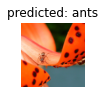

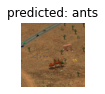

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


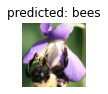

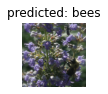

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


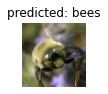

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


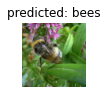

In [18]:
visualize_model(model_ft)

### 场景2：ConvNet作为固定特征提取器

要冻结除最后一层之外的所有网络。  
通过设置requires_grad == Falsebackward()来冻结参数，这样在反向传播backward()的时候他们的梯度就不会被计算。 

In [19]:
model_conv = models.resnet18(pretrained = True)
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features  # 最后fc层的输入
model_conv.fc = nn.Linear(num_ftrs, 2)  # 2在这里表示class的数量

model_conv = model_conv.to(device)

In [20]:
criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr = 0.001, momentum = 0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size = 7, gamma = 0.1)

In [21]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler)

Epoch 0/24
----------
train loss: 0.6226 Acc: 0.6598
val loss: 0.2559 Acc: 0.9020

Epoch 1/24
----------
train loss: 0.5857 Acc: 0.7705
val loss: 0.4765 Acc: 0.7974

Epoch 2/24
----------
train loss: 0.4738 Acc: 0.8033
val loss: 0.2054 Acc: 0.9281

Epoch 3/24
----------
train loss: 0.4081 Acc: 0.8279
val loss: 0.5674 Acc: 0.7712

Epoch 4/24
----------
train loss: 0.5192 Acc: 0.7582
val loss: 0.1766 Acc: 0.9412

Epoch 5/24
----------
train loss: 0.4983 Acc: 0.8115
val loss: 0.1830 Acc: 0.9477

Epoch 6/24
----------
train loss: 0.3654 Acc: 0.8361
val loss: 0.1761 Acc: 0.9477

Epoch 7/24
----------
train loss: 0.4165 Acc: 0.8197
val loss: 0.1883 Acc: 0.9477

Epoch 8/24
----------
train loss: 0.3395 Acc: 0.8648
val loss: 0.2120 Acc: 0.9477

Epoch 9/24
----------
train loss: 0.3530 Acc: 0.8525
val loss: 0.2238 Acc: 0.9281

Epoch 10/24
----------
train loss: 0.3731 Acc: 0.8402
val loss: 0.1737 Acc: 0.9477

Epoch 11/24
----------
train loss: 0.3247 Acc: 0.8361
val loss: 0.1842 Acc: 0.9542

Ep

TypeError: unsupported format string passed to collections.OrderedDict.__format__

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


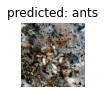

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


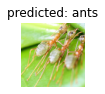

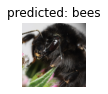

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


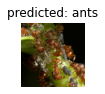

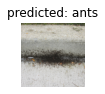

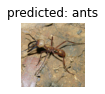

In [24]:
visualize_model(model_conv)